In [1]:
from model import ViTForClassfication

import torch
from torch import nn, optim

import os

In [2]:
import matplotlib.pyplot as plt

In [3]:
from datasets.config import data_config
from datasets import load_data
from trainer import Trainer

In [4]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [5]:
exp_name = 'vit-with-20-epochs'
batch_size = 64
epochs = 2
lr = 1e-4
save_model_every = 0


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
data = 'MNIST'

In [7]:
config = data_config(data)

# These are not hard constraints, but are used to prevent misconfigurations
assert config['hidden_size'] % config['num_attention_heads'] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0

In [8]:
img_size = (config['image_size'], config['image_size'])

In [9]:
img_size

(28, 28)

In [10]:
trainloader, testloader, _ = load_data(
    name=config['name'], img_size=img_size, batch_size=batch_size)

In [11]:
save_model_every_n_epochs = save_model_every

In [12]:
model = ViTForClassfication(config)

In [13]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [14]:
trainer = Trainer(
    model=model, config=config, optimizer=optimizer,
    loss_fn=loss_fn, exp_name=exp_name, device=device
)

In [15]:
trainer.train(
    trainloader, testloader,
    epochs, save_model_every_n_epochs=save_model_every_n_epochs
)

Starting Epoch 1 of 2.


100%|██████████| 938/938 [00:28<00:00, 33.50batch/s]


Epoch: 1, Train loss: 1.8984, Test loss: 1.5488, Accuracy: 0.3994
Starting Epoch 2 of 2.


100%|██████████| 938/938 [00:27<00:00, 34.41batch/s]


Epoch: 2, Train loss: 1.5027, Test loss: 1.3352, Accuracy: 0.4713


# Inspect

In [16]:
from utils import visualize_images, visualize_attention, load_experiment

100%|██████████| 9912422/9912422 [00:01<00:00, 6525100.88it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 55061679.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 12002734.15it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10756933.24it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



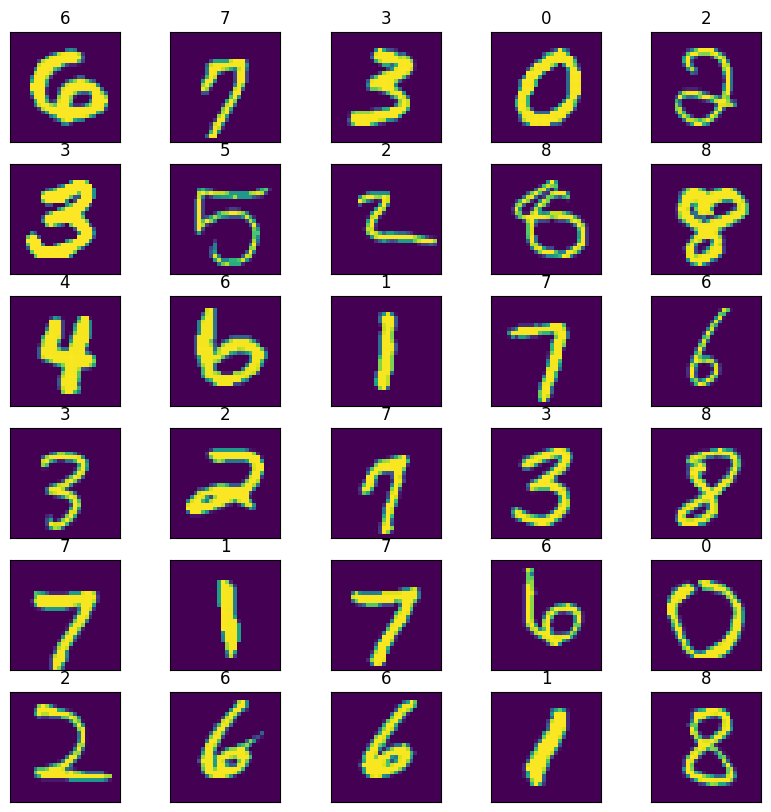

In [17]:
visualize_images('MNIST') # Show some training images

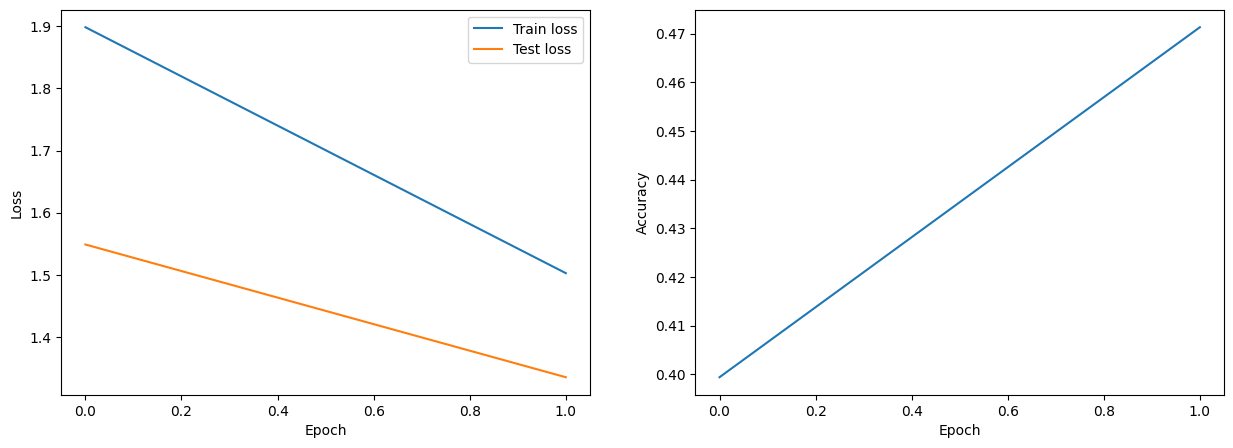

In [18]:
# Load Experiment
config, model, train_losses, test_losses, accuracies = load_experiment("vit-with-20-epochs")

# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

In [19]:
visualize_attention(model,'ImageNet200', "attention.png")

FileNotFoundError: [Errno 2] No such file or directory: 'tiny-imagenet-200/val'